In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('frogs_climate_data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8041 entries, 0 to 8040
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   aet_mean          8041 non-null   float64
 1   def_mean          8041 non-null   float64
 2   pdsi_mean         8041 non-null   float64
 3   ppt_mean          8041 non-null   float64
 4   soil_mean         8041 non-null   float64
 5   tmax_mean         8041 non-null   float64
 6   tmin_mean         8041 non-null   float64
 7   pet_mean          8041 non-null   float64
 8   q_mean            8041 non-null   float64
 9   srad_mean         8041 non-null   float64
 10  swe_mean          8041 non-null   float64
 11  vap_mean          8041 non-null   float64
 12  vpd_mean          8041 non-null   float64
 13  ws_mean           8041 non-null   float64
 14  occurrenceStatus  8041 non-null   int64  
dtypes: float64(14), int64(1)
memory usage: 942.4 KB


In [4]:
vars=['aet_mean', 'def_mean', 'pdsi_mean', 'ppt_mean', 'soil_mean','tmax_mean', 'tmin_mean',
      'pet_mean', 'q_mean', 'srad_mean', 'swe_mean', 'vap_mean', 'vpd_mean', 'ws_mean']

In [5]:
df['occurrenceStatus']=df['occurrenceStatus'].astype(int)

In [6]:
print(f'Null values in the dataset: {df.isnull().sum().sum()}')
print(f'Duplicates values in the dataset: {df.duplicated().sum().sum()}')

Null values in the dataset: 0
Duplicates values in the dataset: 0


# Exploratory Data Analysis

## Target Distribution

In [7]:
df['occurrenceStatus'].value_counts()

occurrenceStatus
0    5524
1    2517
Name: count, dtype: int64

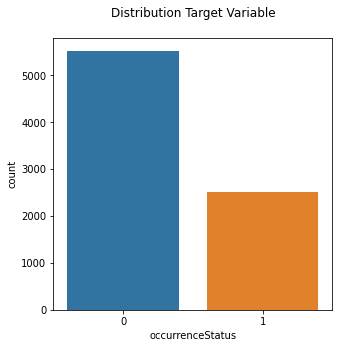

In [8]:
plt.figure(figsize=(5, 5))
sn.countplot(x= df['occurrenceStatus'],order = df['occurrenceStatus'].value_counts().index)
plt.title('Distribution Target Variable\n')
plt.show()

Target variable has imbalanced distribution. 

## Correlation between Target Variable and Features

In [9]:
df.corr()['occurrenceStatus'].sort_values(ascending=False)[1:]

vap_mean     0.578383
tmin_mean    0.477386
aet_mean     0.474908
tmax_mean    0.458989
ppt_mean     0.388445
soil_mean    0.356286
srad_mean    0.320153
pet_mean     0.243057
q_mean       0.192362
pdsi_mean    0.186116
vpd_mean     0.087253
swe_mean    -0.039289
def_mean    -0.199639
ws_mean     -0.225059
Name: occurrenceStatus, dtype: float64

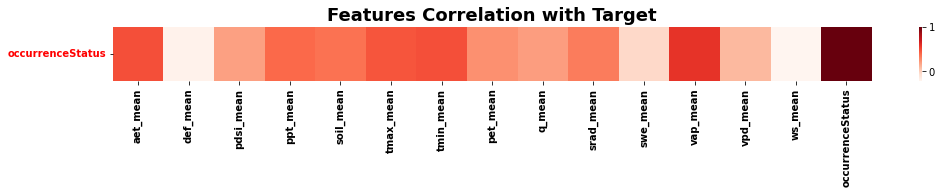

In [10]:
f, ax = plt.subplots(figsize=(17,1))

sn.heatmap(df.corr().sort_values(by=['occurrenceStatus'], ascending=False).head(1), cmap='Reds')
plt.title('Features Correlation with Target', weight='bold', fontsize=18)
plt.xticks(weight='bold')
plt.yticks(weight='bold', color='red', rotation=0)
plt.show()

## Features Distribution

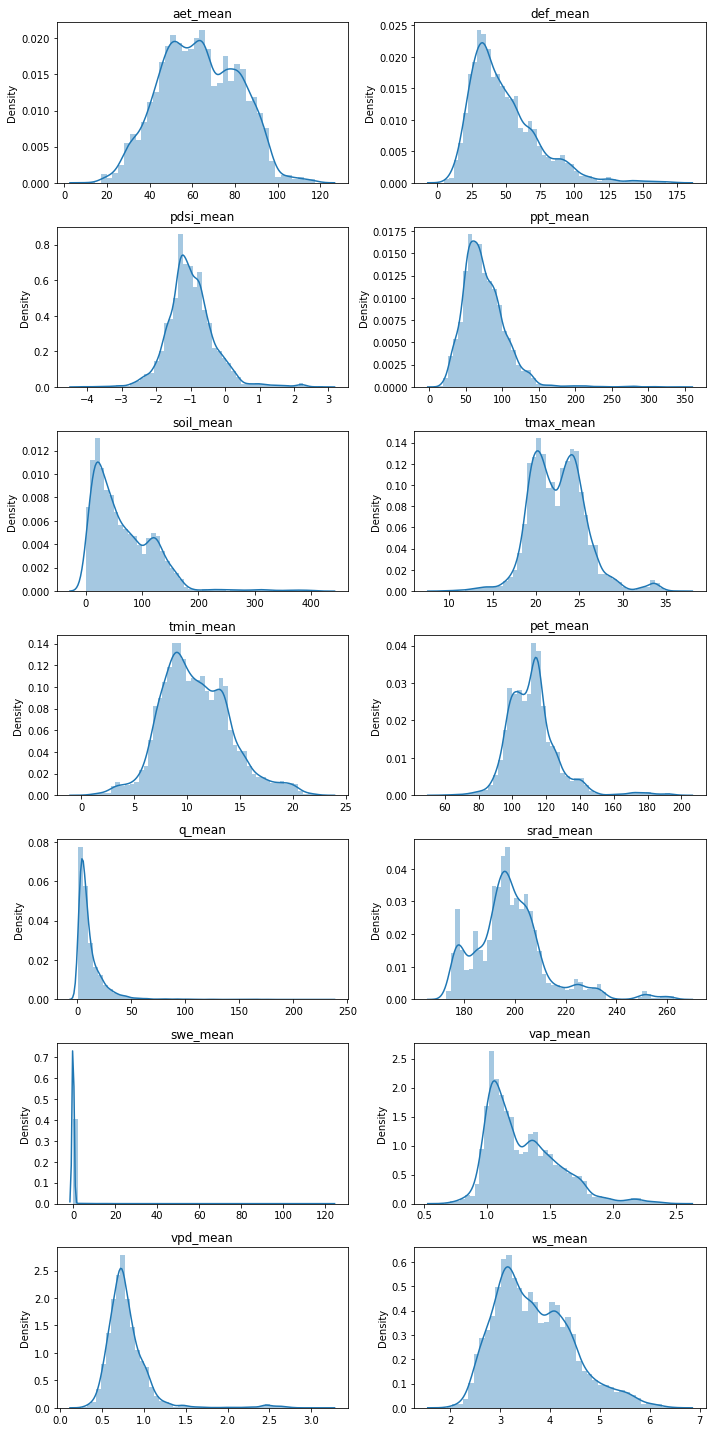

In [11]:
plt.figure(figsize=(10,20))
for ind, value in enumerate(df[vars]):
    plt.subplot(7, 2, ind + 1)
    plt.title(value)
    sn.distplot(df[vars].loc[:, value], axlabel=False)
    plt.tight_layout()

### Log Transformation

The features 'q_mean', 'ppt_mean' and 'vpd_mean' are right-skewed, we will transform these features by function np.log1p

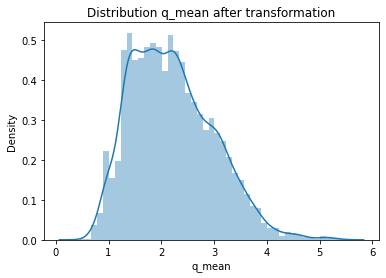

In [12]:
df['q_mean']=np.log1p(df['q_mean'])
sn.distplot(df['q_mean'])
plt.title('Distribution q_mean after transformation')
plt.show()

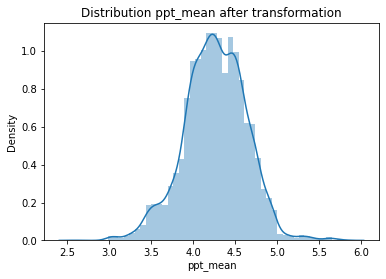

In [13]:
df['ppt_mean']=np.log1p(df['ppt_mean'])
sn.distplot(df['ppt_mean'])
plt.title('Distribution ppt_mean after transformation')
plt.show()

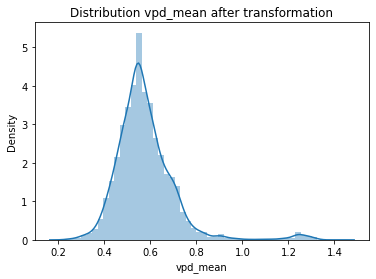

In [14]:
df['vpd_mean']=np.log1p(df['vpd_mean'])
sn.distplot(df['vpd_mean'])
plt.title('Distribution vpd_mean after transformation')
plt.show()

### Eliminate feature 'swe_mean'

The feature 'swe_mean' has 97.8% of a single value. We will eliminate this feature

In [15]:
df['swe_mean']= round(df['swe_mean'],4)
df['swe_mean'].value_counts('%').head()*100

swe_mean
0.0000    97.811218
0.0083     0.186544
0.0167     0.087054
0.0333     0.074618
0.0500     0.037309
Name: proportion, dtype: float64

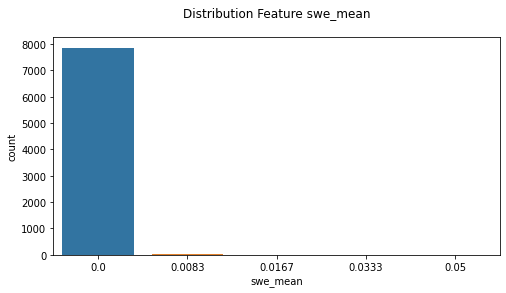

In [16]:
plt.figure(figsize=(8, 4))
sn.countplot(x= df['swe_mean'], order = df['swe_mean'].value_counts().head().index)
plt.title('Distribution Feature swe_mean\n')
plt.show()

In [17]:
df=df.drop(columns=['swe_mean'])

### Correlation between features

In [18]:
vars=['aet_mean', 'def_mean', 'pdsi_mean', 'ppt_mean', 'soil_mean','tmax_mean', 'tmin_mean',
      'pet_mean', 'q_mean', 'srad_mean', 'vap_mean', 'vpd_mean', 'ws_mean']

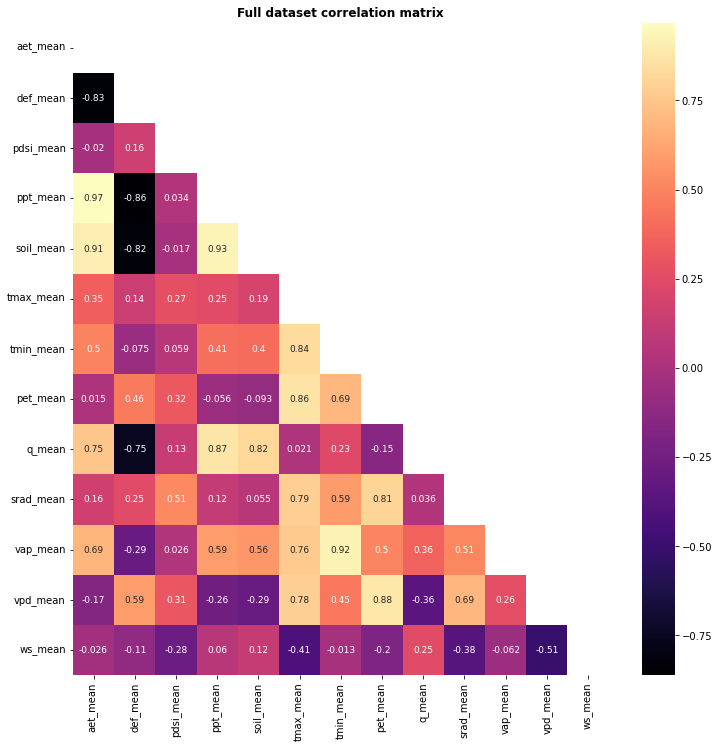

In [19]:
corr = df[vars].corr(method = "spearman")
plt.figure(figsize = (12, 12))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sn.heatmap(corr, mask = mask, cmap = "magma", annot = True, annot_kws = {'size': 9})
plt.title("Full dataset correlation matrix", fontsize = 12, fontweight = "bold")
plt.show()

Since the correlation values between any two variables is not greater than 90%, none of the attributes were removed.

# Train Models

We will train the following 3 models, with cross-validation:

- Random Forest Classifier
- Extra Trees Classifier
- XGBoost Classifier

Later we will fine-tune the models.

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

In [21]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

## Train Random Forest

In [22]:
kfold = KFold(n_splits= 5, shuffle=True, random_state=1)

scores = []

rfc= RandomForestClassifier(random_state = 42)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.occurrenceStatus.values
    y_val = df_val.occurrenceStatus.values

    rfc.fit(df_train[vars], y_train)
    y_pred = rfc.predict_proba(df_val[vars])[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.835 +- 0.013


## Train ExtraTrees

In [23]:
kfold = KFold(n_splits= 5, shuffle=True, random_state=1)

scores = []

xtree= ExtraTreesClassifier(random_state = 42)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.occurrenceStatus.values
    y_val = df_val.occurrenceStatus.values

    xtree.fit(df_train[vars], y_train)
    y_pred = xtree.predict_proba(df_val[vars])[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.655 +- 0.015


## Train XGBoost

In [24]:
kfold = KFold(n_splits= 5, shuffle=True, random_state=1)

scores = []

xgb= XGBClassifier(random_state = 42)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.occurrenceStatus.values
    y_val = df_val.occurrenceStatus.values

    xgb.fit(df_train[vars], y_train)
    y_pred = xgb.predict_proba(df_val[vars])[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.857 +- 0.013


# Model Tunning

In [25]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_tra
del df_val['occurrenceStatus']in.occurrenceStatus.values
y_val = df_val.occurrenceStatus.values
y_test = df_test.occurrenceStatus.values

del df_train['occurrenceStatus']
del df_test['occurrenceStatus']

## Random Forest

In [26]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(df_train[vars], y_train)
y_pred = rfc.predict_proba(df_val[vars])[:, 1]
auc = round(roc_auc_score(y_val, y_pred),3)
auc

0.824

### Tunning n_estimators

In [27]:
scores = []
for n in range(10, 201, 10):
    rfc = RandomForestClassifier(n_estimators=n, random_state=42, n_jobs=-1)
    rfc.fit(df_train[vars], y_train)
    y_pred = rfc.predict_proba(df_val[vars])[:, 1]
    auc = round(roc_auc_score(y_val, y_pred),3)
    scores.append((n, auc))

In [28]:
columns = ['n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores[df_scores['auc']== df_scores['auc'].max()]

,n_estimators,auc
3,40,0.824
8,90,0.824
9,100,0.824


We choose n_estimators=100

### Tunning max_depth

In [29]:
scores = []
n =100
for d in [5, 10, 15, 20, 25]:
    rfc = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=42, n_jobs=-1)
    rfc.fit(df_train[vars], y_train)
    y_pred = rfc.predict_proba(df_val[vars])[:, 1]
    auc = round(roc_auc_score(y_val, y_pred),3)
    scores.append((d,auc))

In [30]:
columns = ['max_depth', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores[df_scores['auc']== df_scores['auc'].max()]

,max_depth,auc
0,5,0.895


We choose max_depth=5

### Tunning min_samples_leaf

In [31]:
scores = []
n=100
depth=5
for msl in [1, 5, 10, 25, 50]:
    rfc = RandomForestClassifier(n_estimators=n, max_depth=depth, min_samples_leaf = msl, random_state=42, n_jobs=-1)
    rfc.fit(df_train[vars], y_train)
    y_pred = rfc.predict_proba(df_val[vars])[:, 1]
    auc = round(roc_auc_score(y_val, y_pred),3)
    scores.append((msl,auc))

In [32]:
columns = ['min_sample_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores[df_scores['auc']== df_scores['auc'].max()]

,min_sample_leaf,auc
0,1,0.895
2,10,0.895


We choose min_samples_leaf=1

### Train model with new parameters

In [33]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf = 1, random_state=42, n_jobs=-1)
rfc.fit(df_train[vars], y_train)
y_pred = rfc.predict_proba(df_val[vars])[:, 1]
auc = round(roc_auc_score(y_val, y_pred),3)
auc

0.895

One of the best configuration for the Random Forest model is: n_estimators = 100, max_depth = 5 and min_samples_leaf = 1.

With these parameters the roc_auc_score is 0.895.

## Extra Trees

In [34]:
xtree= ExtraTreesClassifier(random_state = 42)
xtree.fit(df_train[vars], y_train)
y_pred = xtree.predict_proba(df_val[vars])[:, 1]
auc = round(roc_auc_score(y_val, y_pred),3)
auc

0.664

### Tunning n_estimators

In [35]:
scores = []
for n in range(5, 206, 10):
    xtree= ExtraTreesClassifier(n_estimators=n, random_state=42, n_jobs=-1)
    xtree.fit(df_train[vars], y_train)
    y_pred = xtree.predict_proba(df_val[vars])[:, 1]
    auc = round(roc_auc_score(y_val, y_pred),3)
    scores.append((n, auc))

In [36]:
columns = ['n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores[df_scores['auc']== df_scores['auc'].max()]

,n_estimators,auc
0,5,0.694


We choose n_estimators=5

### Tunning max_depth

In [37]:
scores = []
n =5
for d in [3, 5, 10, 15, 20, 25]:
    xtree= ExtraTreesClassifier(n_estimators=n, max_depth=d, random_state=42, n_jobs=-1)
    xtree.fit(df_train[vars], y_train)
    y_pred = xtree.predict_proba(df_val[vars])[:, 1]
    auc = round(roc_auc_score(y_val, y_pred),3)
    scores.append((d,auc))

In [38]:
columns = ['max_depth', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores[df_scores['auc']== df_scores['auc'].max()]

,max_depth,auc
2,10,0.886


We choose max_depth= 10

### Tunning min_samples_leaf

In [39]:
scores = []
n = 5
d= 10
for msl in [1, 2, 5, 10, 20, 30]:
    xtree= ExtraTreesClassifier(n_estimators=n, max_depth=d, min_samples_leaf = msl, random_state=42, n_jobs=-1)
    xtree.fit(df_train[vars], y_train)
    y_pred = xtree.predict_proba(df_val[vars])[:, 1]
    auc = round(roc_auc_score(y_val, y_pred),3)
    scores.append((msl, auc))

In [40]:
columns = ['min_sample_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores[df_scores['auc']== df_scores['auc'].max()]

,min_sample_leaf,auc
3,10,0.892


We choose min_samples_leaf= 10

### Train model with new parameters

In [41]:
xtree= ExtraTreesClassifier(n_estimators=5, max_depth=10, min_samples_leaf = 10, random_state=42, n_jobs=-1)
xtree.fit(df_train[vars], y_train)
y_pred = xtree.predict_proba(df_val[vars])[:, 1]
auc = round(roc_auc_score(y_val, y_pred),3)
auc

0.892

One of the best configuration for the Extra Trees model is: n_estimators = 5, max_depth = 10 and min_samples_leaf = 10.

With these parameters the roc_auc_score is 0.892.

## XGBoost

In [42]:
xgb= XGBClassifier(random_state = 42)
xgb.fit(df_train[vars], y_train)
y_pred = xgb.predict_proba(df_val[vars])[:, 1]
auc = round(roc_auc_score(y_val, y_pred),3)
auc

0.837

### Tunning n_estimators

In [43]:
scores = []
for n in range(5, 206, 10):
    xgb= XGBClassifier(n_estimators=n, random_state=42, n_jobs=-1)
    xgb.fit(df_train[vars], y_train)
    y_pred = xgb.predict_proba(df_val[vars])[:, 1]
    auc = round(roc_auc_score(y_val, y_pred),3)
    scores.append((n, auc))

In [44]:
columns = ['n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores[df_scores['auc']== df_scores['auc'].max()]

,n_estimators,auc
0,5,0.888


We choose n_estimators = 5

### Tunning eta

In [45]:
scores = []
n=5
for e in [0.01, 0.1, 0.2, 0.3, 0.5]:
    xgb= XGBClassifier(n_estimators=n, eta=e, random_state=42, n_jobs=-1)
    xgb.fit(df_train[vars], y_train)
    y_pred = xgb.predict_proba(df_val[vars])[:, 1]
    auc = round(roc_auc_score(y_val, y_pred),3)
    scores.append((e, auc))

In [46]:
columns = ['eta', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores[df_scores['auc']== df_scores['auc'].max()]

,eta,auc
1,0.1,0.892


We choose eta= 0.1

### Tunning max_depth

In [47]:
scores = []
n= 5
e= 0.1
for d in [3, 6, 10, 15, 20, 25]:
    xgb= XGBClassifier(n_estimators=n, eta=e, max_depth=d, random_state=42, n_jobs=-1)
    xgb.fit(df_train[vars], y_train)
    y_pred = xgb.predict_proba(df_val[vars])[:, 1]
    auc = round(roc_auc_score(y_val, y_pred),3)
    scores.append((d, auc))

In [48]:
columns = ['max_depth', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores[df_scores['auc']== df_scores['auc'].max()]

,max_depth,auc
1,6,0.892


We choose max_depth = 6

### Train model with new parameters

In [49]:
xgb= XGBClassifier(n_estimators=5, eta=0.1, max_depth=6, random_state=42, n_jobs=-1)
xgb.fit(df_train[vars], y_train)
y_pred = xgb.predict_proba(df_val[vars])[:, 1]
auc = round(roc_auc_score(y_val, y_pred),3)
auc

0.892

One of the best configuration for the XGBoost Classifier model is: n_estimators= 5, eta= 0.1 and max_depth= 6.

With these parameters the roc_auc_score is 0.892.

# Choose Final Model 

To choose the final model, we will train the tuned models with data from df_full_train and evaluate their performance with df_test

In [50]:
df_full_train=df_full_train.reset_index(drop=True)
y_full_train=df_full_train.occurrenceStatus.values

In [51]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf = 1, random_state=42, n_jobs=-1)
rfc.fit(df_full_train[vars], y_full_train)
y_pred = rfc.predict_proba(df_test[vars])[:, 1]
auc = round(roc_auc_score(y_test, y_pred),3)
auc

0.902

In [52]:
xtree= ExtraTreesClassifier(n_estimators=5, max_depth=10, min_samples_leaf = 10, random_state=42, n_jobs=-1)
xtree.fit(df_full_train[vars], y_full_train)
y_pred = xtree.predict_proba(df_test[vars])[:, 1]
auc = round(roc_auc_score(y_test, y_pred),3)
auc

0.898

In [53]:
xgb= XGBClassifier(n_estimators=5, eta=0.1, max_depth=6, random_state=42, n_jobs=-1)
xgb.fit(df_full_train[vars], y_full_train)
y_pred = xgb.predict_proba(df_test[vars])[:, 1]
auc = round(roc_auc_score(y_test, y_pred),3)
auc

0.899

#### The best performing model is Random Forest Classifier (n_estimators=100, max_depth=5, min_samples_leaf = 1).

#### This model has a roc_auc_core= 0.902 which is slightly higher than the other models.

#### We choose this model to deploy.